In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")


## Step 1: Load Data & Initial Inspection

loading the dataset and reviewing its structure, including column types, missing values, and general statistics.


In [ ]:
df = pd.read_csv("/content/data (1).csv")
df.head()


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [ ]:
df.info()
missing = df.isnull().mean() * 100
missing[missing > 0].sort_values()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


,0
VALUE,1.879195
CLNO,3.724832
REASON,4.228188
JOB,4.681208
CLAGE,5.167785
NINQ,8.557047
YOJ,8.640940
MORTDUE,8.691275
DELINQ,9.731544
DEROG,11.879195


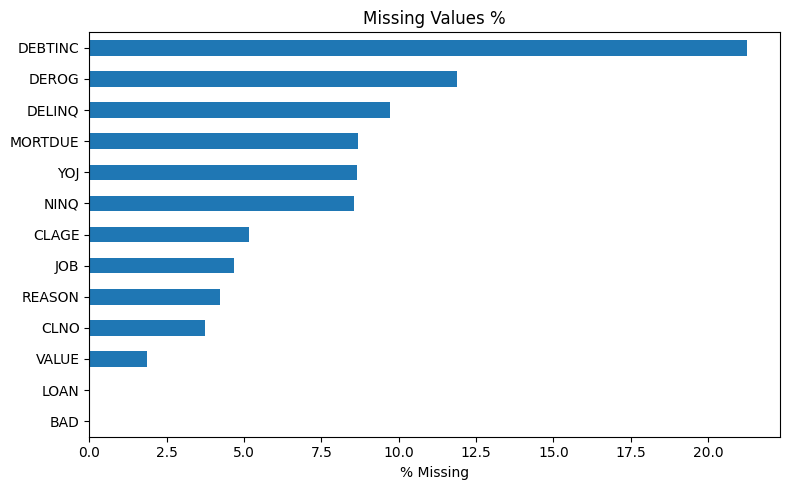

In [ ]:
missing.sort_values().plot(kind='barh', figsize=(8, 5), title="Missing Values %")
plt.xlabel("% Missing")
plt.tight_layout()
plt.show()


## Step 2: Exploratory Data Analysis (EDA)

Explore the distribution of numerical variables and look at correlations.


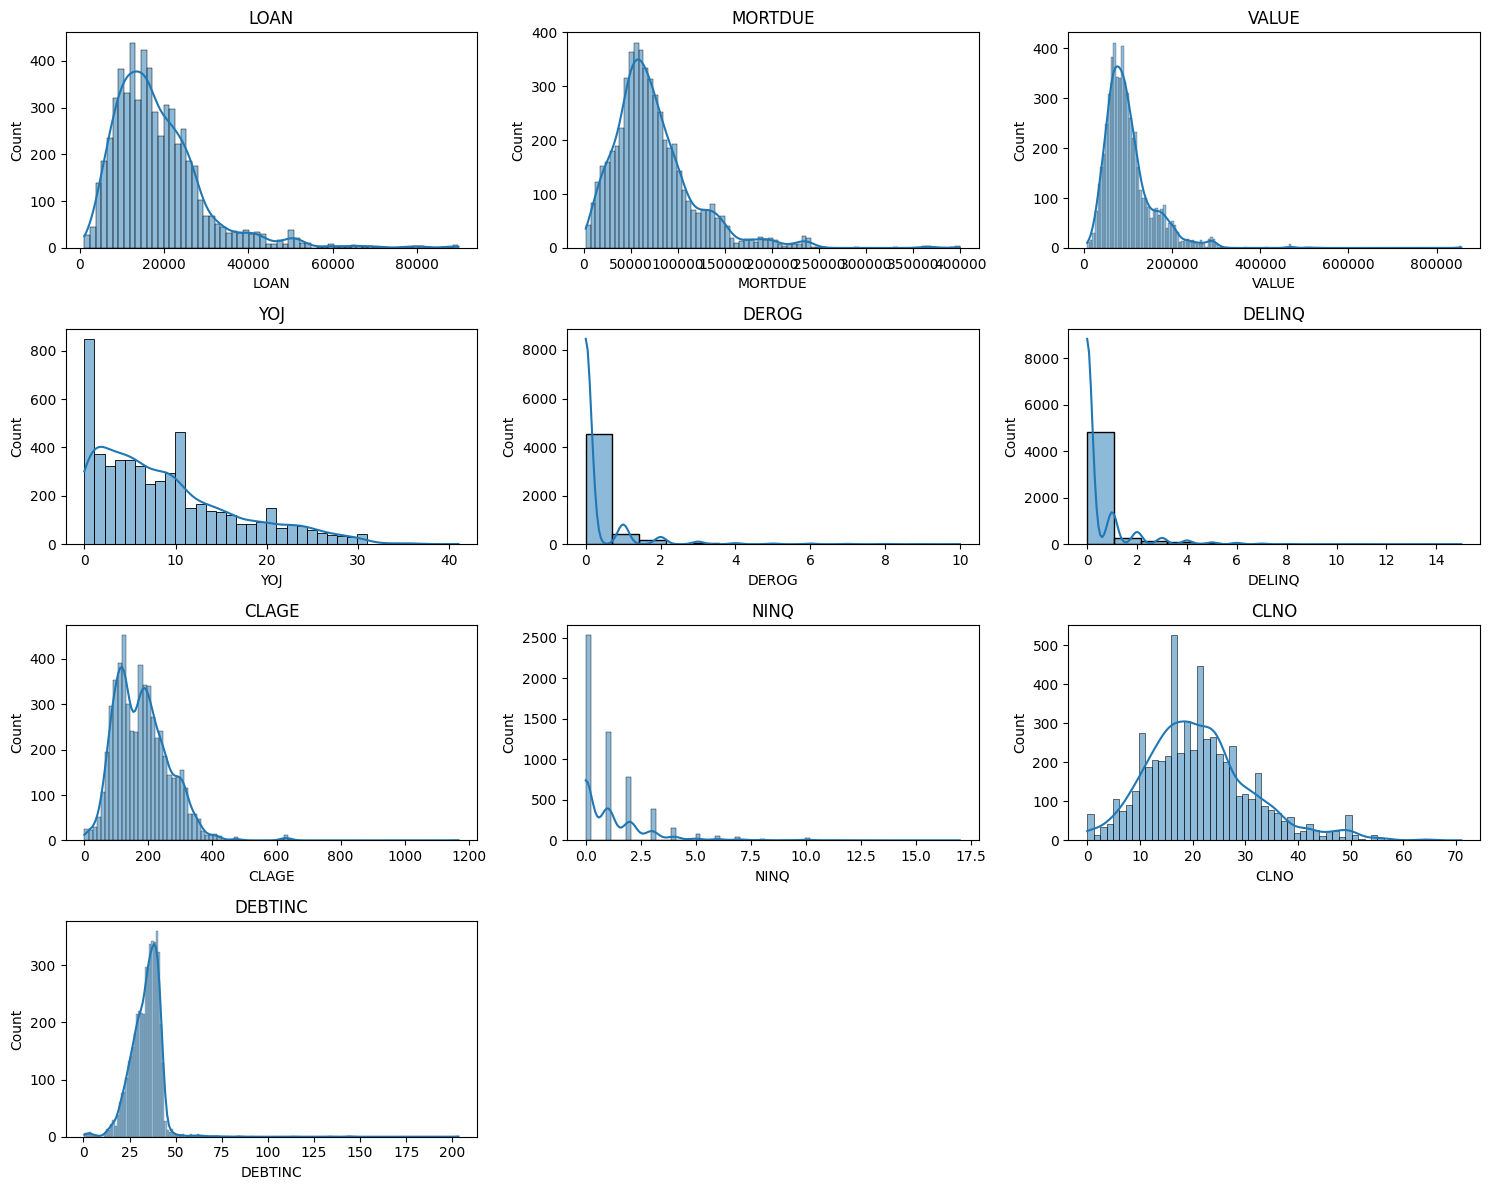

In [ ]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('BAD')
plt.figure(figsize=(15, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()


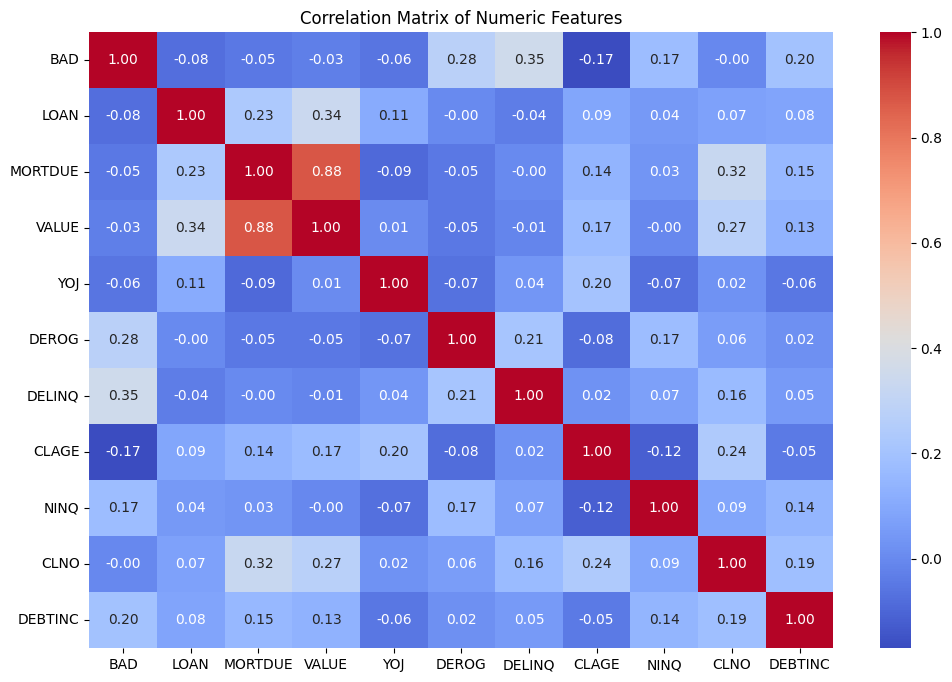

In [ ]:
# Filter only numeric columns before computing correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()


Outlier Detection

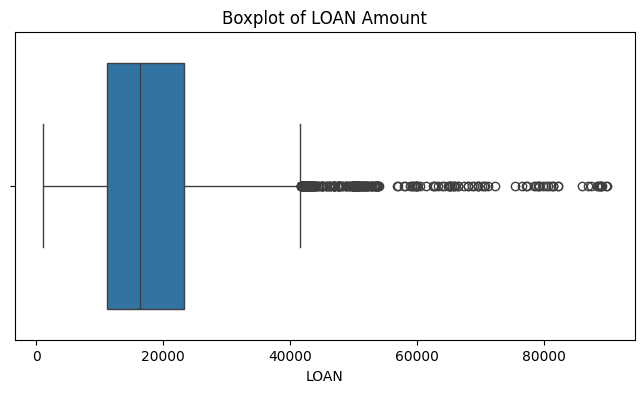

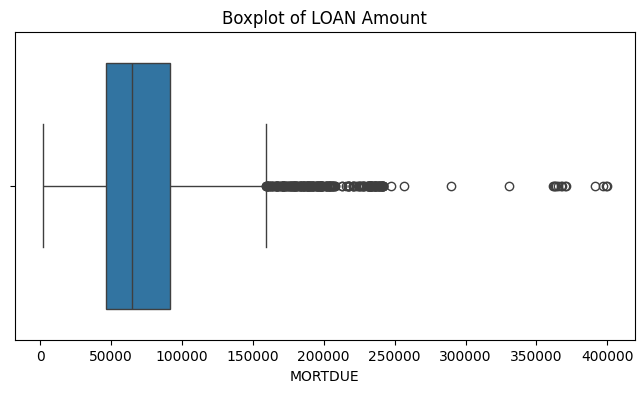

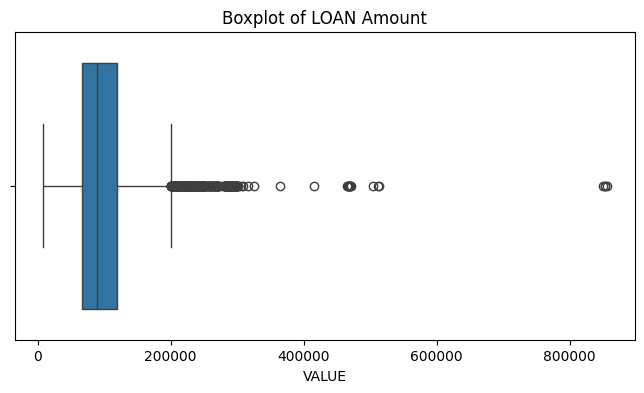

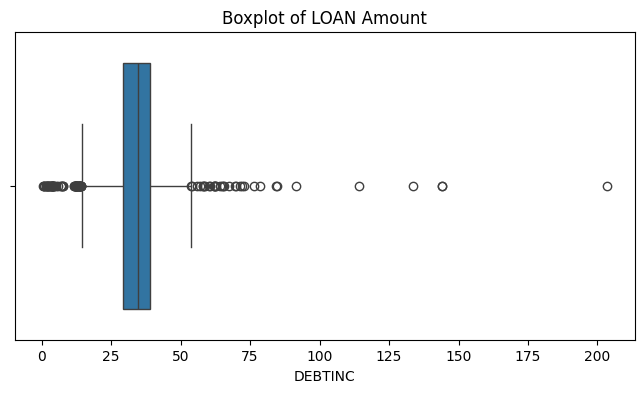

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['LOAN'])
plt.title("Boxplot of LOAN Amount")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x=df['MORTDUE'])
plt.title("Boxplot of LOAN Amount")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x=df['VALUE'])
plt.title("Boxplot of LOAN Amount")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x=df['DEBTINC'])
plt.title("Boxplot of LOAN Amount")
plt.show()

Bivariate Relationships

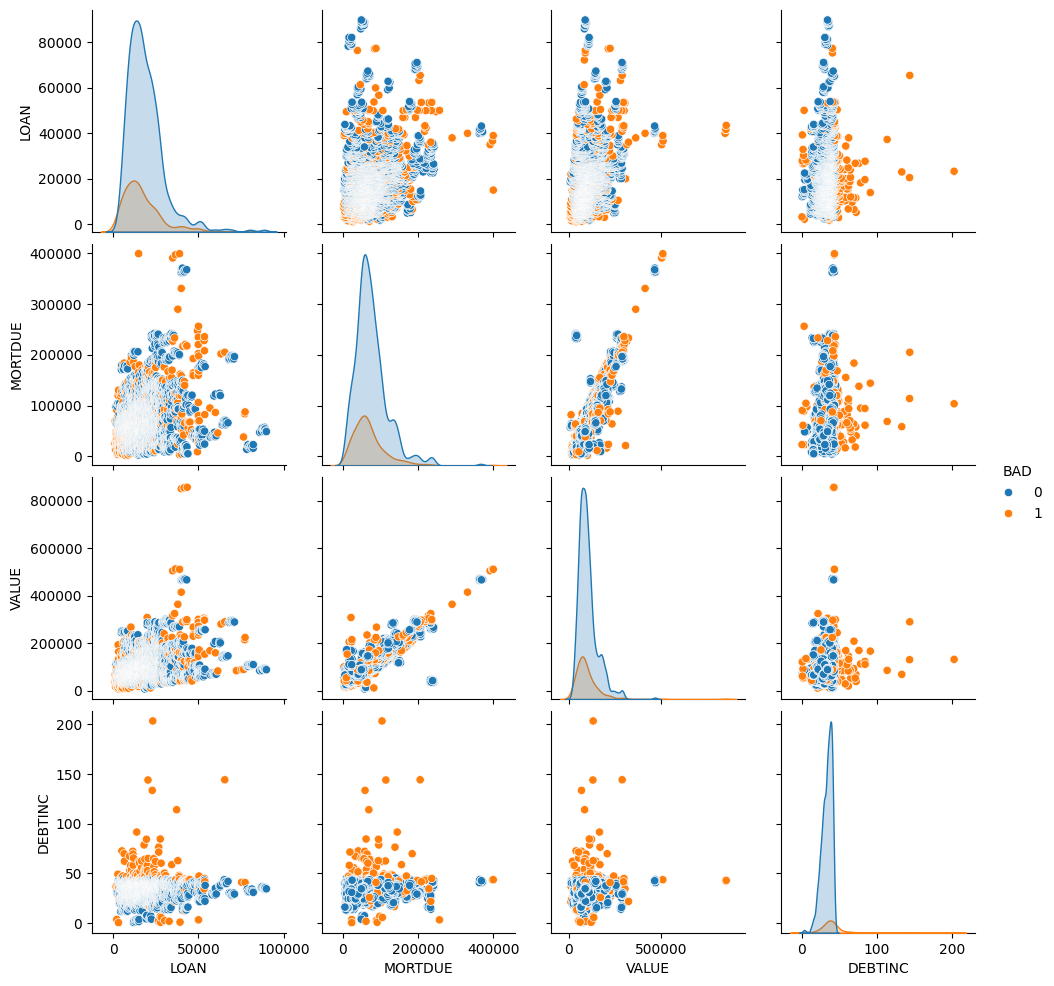

In [ ]:
sns.pairplot(df, vars=['LOAN', 'MORTDUE', 'VALUE', 'DEBTINC'], hue='BAD')


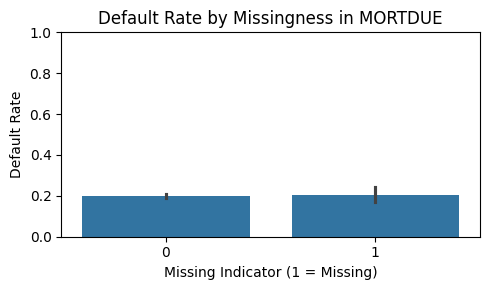

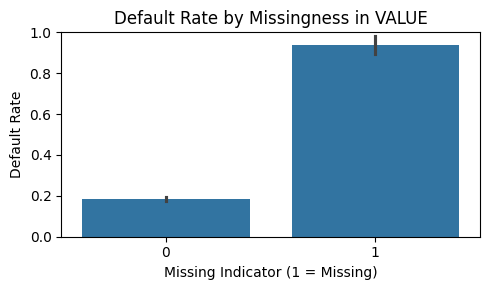

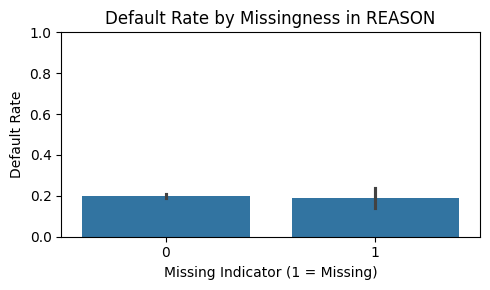

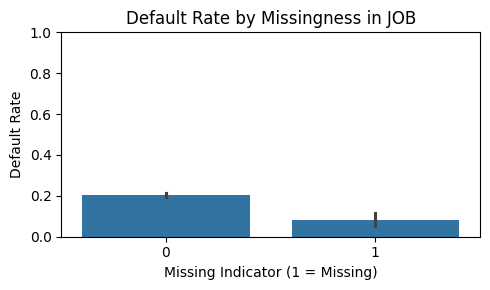

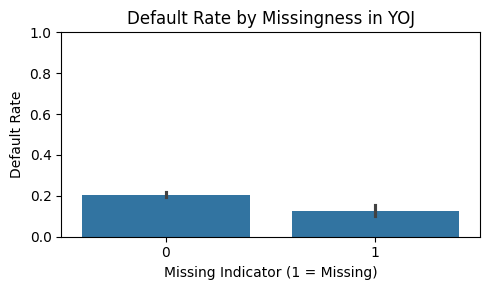

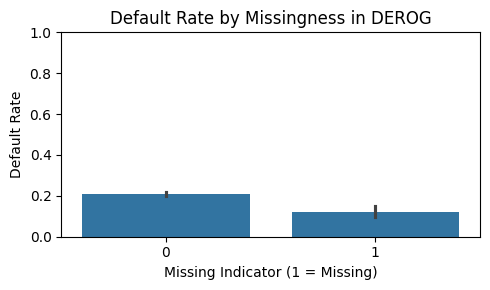

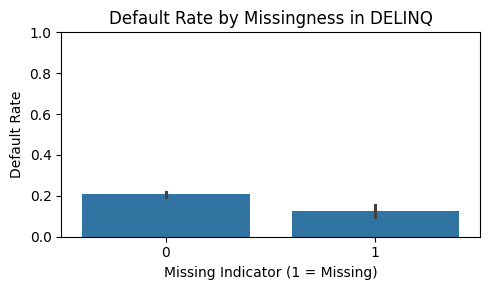

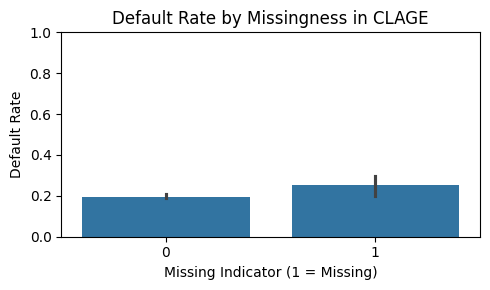

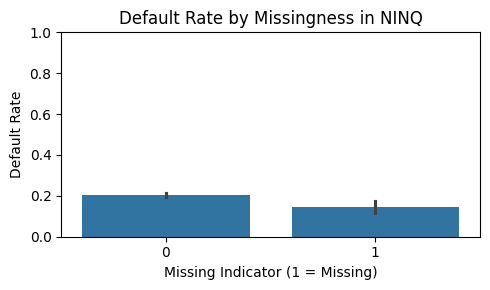

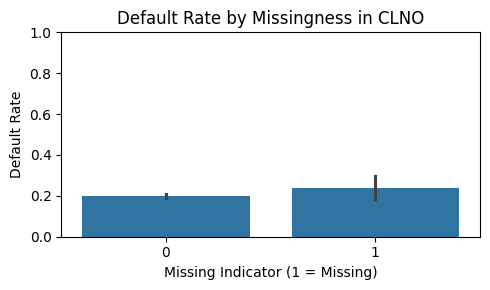

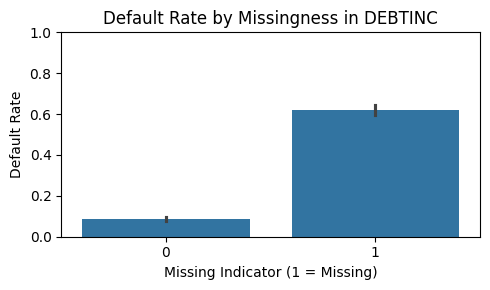

In [ ]:
# Use a separate copy for missingness analysis (do not modify original df)
df_eda = df.copy()

missing_cols = df_eda.columns[df_eda.isnull().any()]

for col in missing_cols:
    indicator = f"{col}_missing"
    df_eda[indicator] = df_eda[col].isnull().astype(int)

    plt.figure(figsize=(5, 3))
    sns.barplot(x=indicator, y='BAD', data=df_eda)
    plt.title(f'Default Rate by Missingness in {col}')
    plt.xlabel('Missing Indicator (1 = Missing)')
    plt.ylabel('Default Rate')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


## Step 3: Preprocessing & Imputation

Impute missing values using:
- **Mean for numerical features**
- **Median for numerical features**
- **Mode for categorical features**

Then encode categorical variables and scale features.


In [ ]:
impute_strategies = ['mean', 'median', 'most_frequent']
results = {}

for strategy in impute_strategies:
    # Copy original data
    df_temp = df.copy()

    # Identify types
    num_cols = df_temp.select_dtypes(include=['float64', 'int64']).columns.drop('BAD')
    cat_cols = df_temp.select_dtypes(include='object').columns

    # Impute categorical always with mode
    df_temp[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(df_temp[cat_cols])

    # Impute numeric with chosen strategy
    df_temp[num_cols] = SimpleImputer(strategy=strategy).fit_transform(df_temp[num_cols])

    # Encode categorical variables
    df_temp['REASON'] = LabelEncoder().fit_transform(df_temp['REASON'])
    df_temp['JOB'] = LabelEncoder().fit_transform(df_temp['JOB'])

    # Feature and target separation
    X_temp = df_temp.drop(columns='BAD')
    y_temp = df_temp['BAD']

    # Scaling
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_temp), columns=X_temp.columns)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_temp, test_size=0.3, stratify=y_temp, random_state=42)

    # Train Logistic Regression
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    # Evaluate using ROC-AUC
    auc = roc_auc_score(y_test, y_pred)
    results[strategy] = auc

# Print results
for method, score in results.items():
    print(f"{method.capitalize()} Imputation AUC: {score:.4f}")

Mean Imputation AUC: 0.7695
Median Imputation AUC: 0.7799
Most_frequent Imputation AUC: 0.8321


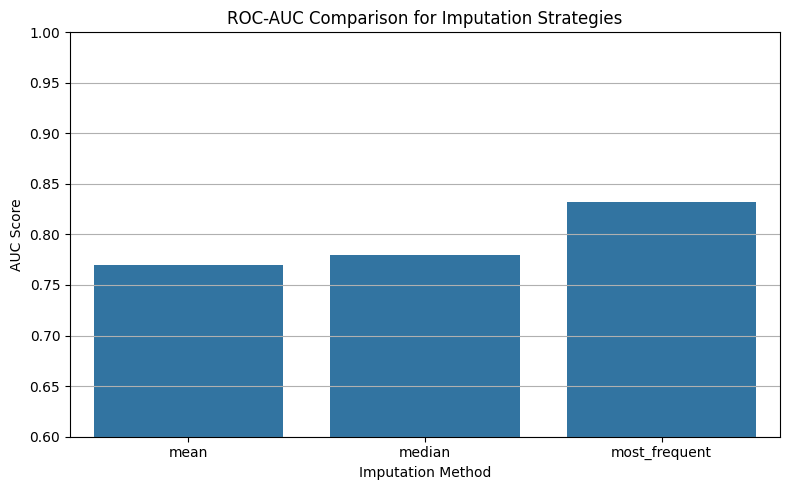

In [ ]:
# Visualize AUC comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("ROC-AUC Comparison for Imputation Strategies")
plt.ylabel("AUC Score")
plt.xlabel("Imputation Method")
plt.ylim(0.6, 1.0)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


## Step 4: Class imbalance

###  Undersampling
In this step, I have create **two versions of each imputed dataset**:
1. **Original (Imbalanced)**
2. **Balanced (Upsampling)**
3. **Balanced (Undersampling)**

Applied this strategy for imputation methods:
- `median` imputation


These datasets will be used in the next step to compare model performance across imputation strategies **and** class balance conditions.


In [ ]:
# Step 1: Prepare original, upsampled, and undersampled datasets

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample

# Load data
df = pd.read_csv("/content/data (1).csv")  # Update path if needed

# Impute: median for numeric, mode for categorical
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('BAD')
cat_cols = df.select_dtypes(include='object').columns

df[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(df[cat_cols])
df[num_cols] = SimpleImputer(strategy='median').fit_transform(df[num_cols])

# Encode categorical
df['REASON'] = LabelEncoder().fit_transform(df['REASON'])
df['JOB'] = LabelEncoder().fit_transform(df['JOB'])

# Separate features and target
X = df.drop(columns='BAD')
y = df['BAD']

# Create combined DataFrame
df_combined = pd.concat([X, y], axis=1)
df_majority = df_combined[df_combined.BAD == 0]
df_minority = df_combined[df_combined.BAD == 1]

# === 1. ORIGINAL (Imbalanced) ===
X_original = X.copy()
y_original = y.copy()

# === 2. UPSAMPLED (Balanced) ===
df_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_bal_up = pd.concat([df_majority, df_upsampled])
X_upsampled = df_bal_up.drop(columns='BAD')
y_upsampled = df_bal_up['BAD']

# === 3. UNDERSAMPLED (Balanced) ===
df_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)
df_bal_down = pd.concat([df_downsampled, df_minority])
X_undersampled = df_bal_down.drop(columns='BAD')
y_undersampled = df_bal_down['BAD']

# === Standardize All ===
scaler = StandardScaler()
X_original_scaled = pd.DataFrame(scaler.fit_transform(X_original), columns=X.columns)
X_upsampled_scaled = pd.DataFrame(scaler.fit_transform(X_upsampled), columns=X.columns)
X_undersampled_scaled = pd.DataFrame(scaler.fit_transform(X_undersampled), columns=X.columns)


Step 2: Train Logistic Regression and SVM on all datasets and compare ROC curves

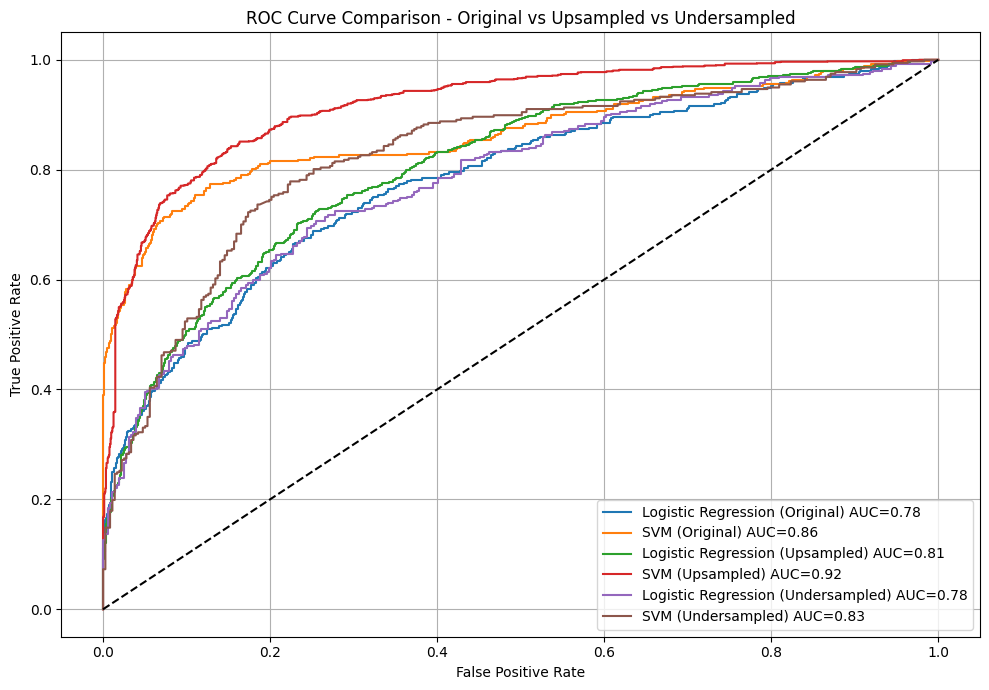

AUC Scores:
Logistic Regression (Original): 0.7799
SVM (Original): 0.8648
Logistic Regression (Upsampled): 0.8075
SVM (Upsampled): 0.9187
Logistic Regression (Undersampled): 0.7826
SVM (Undersampled): 0.8268


In [ ]:
# Step 2: Train Logistic Regression and SVM on all datasets and compare ROC curves

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Store ROC data
roc_data = []

# Function to train both models and capture ROC metrics
def train_and_evaluate(X_scaled, y, label):
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, stratify=y, random_state=42
    )

    # Logistic Regression
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    lr_probs = lr.predict_proba(X_test)[:, 1]
    auc_lr = roc_auc_score(y_test, lr_probs)
    fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
    roc_data.append(('Logistic Regression', label, fpr_lr, tpr_lr, auc_lr))

    # SVM with probability=True for ROC-AUC
    svm = SVC(kernel='rbf', probability=True)
    svm.fit(X_train, y_train)
    svm_probs = svm.predict_proba(X_test)[:, 1]
    auc_svm = roc_auc_score(y_test, svm_probs)
    fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
    roc_data.append(('SVM', label, fpr_svm, tpr_svm, auc_svm))

# Train and evaluate on each dataset
train_and_evaluate(X_original_scaled, y_original, 'Original')
train_and_evaluate(X_upsampled_scaled, y_upsampled, 'Upsampled')
train_and_evaluate(X_undersampled_scaled, y_undersampled, 'Undersampled')

# Plot ROC curves
plt.figure(figsize=(10, 7))
for model, label, fpr, tpr, auc in roc_data:
    plt.plot(fpr, tpr, label=f'{model} ({label}) AUC={auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison - Original vs Upsampled vs Undersampled")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print AUC scores for reference
print("AUC Scores:")
for model, label, _, _, auc in roc_data:
    print(f"{model} ({label}): {auc:.4f}")


 Step 3: Threshold tuning and evaluation

In [90]:
# Step 3: Threshold tuning and evaluation

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Define thresholds to test
thresholds = np.arange(0.2, 0.81, 0.05)

# Store all results
threshold_results = []

# Reuse model predictions from step 2
# Note: Use predictions stored in roc_data (already trained and tested)

# Step 3 helper: Evaluate thresholds
def evaluate_thresholds(probs, y_true, model_name, data_label):
    for thresh in thresholds:
        y_pred = (probs >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        threshold_results.append({
            'Model': model_name,
            'Dataset': data_label,
            'Threshold': round(thresh, 2),
            'Recall_BAD (≥85%)': tp / (tp + fn),
            'Recall_GOOD (≥70%)': tn / (tn + fp),
            'Precision': precision_score(y_true, y_pred),
            'F1 Score': f1_score(y_true, y_pred),
            'Accuracy': (tp + tn) / (tp + tn + fp + fn),
            'TP': tp,
            'FP': fp,
            'TN': tn,
            'FN': fn
        })

# Extract probability predictions from roc_data structure
# roc_data = (model_name, dataset_label, fpr, tpr, auc)
# We'll need to retrain to get y_test and prob predictions again with matching order

# Helper to retrain and generate thresholds
def get_predictions_and_evaluate(X_scaled, y, label):
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, stratify=y, random_state=42
    )

    # Logistic Regression
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    lr_probs = lr.predict_proba(X_test)[:, 1]
    evaluate_thresholds(lr_probs, y_test, "Logistic Regression", label)

    # SVM
    svm = SVC(kernel='rbf', probability=True)
    svm.fit(X_train, y_train)
    svm_probs = svm.predict_proba(X_test)[:, 1]
    evaluate_thresholds(svm_probs, y_test, "SVM", label)

# Evaluate thresholds on all datasets
get_predictions_and_evaluate(X_original_scaled, y_original, 'Original')
get_predictions_and_evaluate(X_upsampled_scaled, y_upsampled, 'Upsampled')
get_predictions_and_evaluate(X_undersampled_scaled, y_undersampled, 'Undersampled')

# Create results DataFrame
threshold_df = pd.DataFrame(threshold_results)



In [88]:
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Define thresholds
thresholds = np.arange(0.2, 0.81, 0.05)
threshold_results = []

# Helper: evaluate all thresholds
def evaluate_thresholds(probs, y_true, model_name, dataset_name):
    for thresh in thresholds:
        y_pred = (probs >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        threshold_results.append({
            'Model': model_name,
            'Dataset': dataset_name,
            'Threshold': round(thresh, 2),
            'Recall_BAD (≥85%)': tp / (tp + fn),
            'Recall_GOOD (≥70%)': tn / (tn + fp),
            'Precision': precision_score(y_true, y_pred),
            'F1 Score': f1_score(y_true, y_pred),
            'Accuracy': (tp + tn) / (tp + tn + fp + fn),
            'TP': tp,
            'FP': fp,
            'TN': tn,
            'FN': fn
        })

# Helper: train model and evaluate thresholds
def train_and_evaluate_thresholds(X_scaled, y, dataset_name):
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, stratify=y, random_state=42
    )

    # Logistic Regression
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    lr_probs = lr.predict_proba(X_test)[:, 1]
    evaluate_thresholds(lr_probs, y_test, "Logistic Regression", dataset_name)

    # SVM
    svm = SVC(kernel='rbf', probability=True)
    svm.fit(X_train, y_train)
    svm_probs = svm.predict_proba(X_test)[:, 1]
    evaluate_thresholds(svm_probs, y_test, "SVM", dataset_name)

# Evaluate thresholds for all 3 datasets
train_and_evaluate_thresholds(X_original_scaled, y_original, 'Original')
train_and_evaluate_thresholds(X_upsampled_scaled, y_upsampled, 'Upsampled')
train_and_evaluate_thresholds(X_undersampled_scaled, y_undersampled, 'Undersampled')

# Convert to DataFrame
threshold_df = pd.DataFrame(threshold_results)

# Helper: extract best thresholds for Objectives A, B, C
def get_best_thresholds(df):
    summary = []

    for model in df['Model'].unique():
        for dataset in df['Dataset'].unique():
            subset = df[(df['Model'] == model) & (df['Dataset'] == dataset)]

            # Objective A
            obj_a = subset[subset['Recall_BAD (≥85%)'] >= 0.85]
            best_a = obj_a.sort_values(by='Recall_BAD (≥85%)', ascending=False).head(1)

            # Objective B
            obj_b = subset[subset['Recall_GOOD (≥70%)'] >= 0.70]
            best_b = obj_b.sort_values(by='Recall_GOOD (≥70%)', ascending=False).head(1)

            # Objective C
            best_c = subset.sort_values(by='F1 Score', ascending=False).head(1)

            if not best_a.empty:
                row = best_a.iloc[0]
                summary.append({
                    'Model': model,
                    'Dataset': dataset,
                    'Objective': 'A (≥85% Recall BAD)',
                    'Threshold': row['Threshold'],
                    'Recall_BAD': round(row['Recall_BAD (≥85%)'], 3),
                    'Recall_GOOD': round(row['Recall_GOOD (≥70%)'], 3),
                    'F1': round(row['F1 Score'], 3),
                    'Accuracy': round(row['Accuracy'], 3)
                })

            if not best_b.empty:
                row = best_b.iloc[0]
                summary.append({
                    'Model': model,
                    'Dataset': dataset,
                    'Objective': 'B (≥70% Recall GOOD)',
                    'Threshold': row['Threshold'],
                    'Recall_BAD': round(row['Recall_BAD (≥85%)'], 3),
                    'Recall_GOOD': round(row['Recall_GOOD (≥70%)'], 3),
                    'F1': round(row['F1 Score'], 3),
                    'Accuracy': round(row['Accuracy'], 3)
                })

            row = best_c.iloc[0]
            summary.append({
                'Model': model,
                'Dataset': dataset,
                'Objective': 'C (Best F1 Score)',
                'Threshold': row['Threshold'],
                'Recall_BAD': round(row['Recall_BAD (≥85%)'], 3),
                'Recall_GOOD': round(row['Recall_GOOD (≥70%)'], 3),
                'F1': round(row['F1 Score'], 3),
                'Accuracy': round(row['Accuracy'], 3)
            })

    return pd.DataFrame(summary)

# Generate and show summary
summary_table = get_best_thresholds(threshold_df)
summary_table.sort_values(by=['Model', 'Dataset', 'Objective'], inplace=True)

# Display the final summary
print("\n🔍 Final Summary Table: Best Thresholds by Objective")
print(summary_table.to_string(index=False))



🔍 Final Summary Table: Best Thresholds by Objective
              Model      Dataset            Objective  Threshold  Recall_BAD  Recall_GOOD    F1  Accuracy
Logistic Regression     Original B (≥70% Recall GOOD)       0.80       0.151        0.997 0.260     0.828
Logistic Regression     Original    C (Best F1 Score)       0.20       0.622        0.803 0.516     0.767
Logistic Regression Undersampled  A (≥85% Recall BAD)       0.20       0.950        0.244 0.702     0.597
Logistic Regression Undersampled B (≥70% Recall GOOD)       0.80       0.317        0.966 0.469     0.641
Logistic Regression Undersampled    C (Best F1 Score)       0.35       0.821        0.552 0.723     0.686
Logistic Regression    Upsampled  A (≥85% Recall BAD)       0.20       0.973        0.184 0.697     0.578
Logistic Regression    Upsampled B (≥70% Recall GOOD)       0.80       0.300        0.969 0.451     0.635
Logistic Regression    Upsampled    C (Best F1 Score)       0.35       0.854        0.552 0.742    

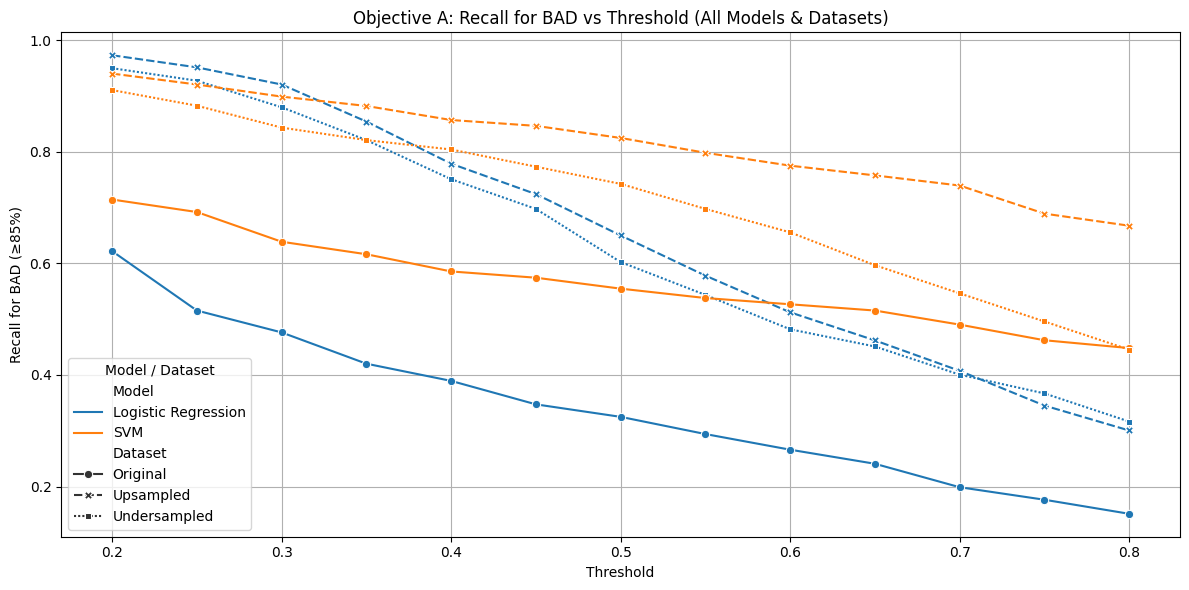

In [97]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=threshold_df, x="Threshold", y="Recall_BAD (≥85%)", hue="Model", style="Dataset", markers=True)
plt.title("Objective A: Recall for BAD vs Threshold (All Models & Datasets)")
plt.xlabel("Threshold")
plt.ylabel("Recall for BAD (≥85%)")
plt.grid(True)
plt.legend(title="Model / Dataset")
plt.tight_layout()
plt.show()


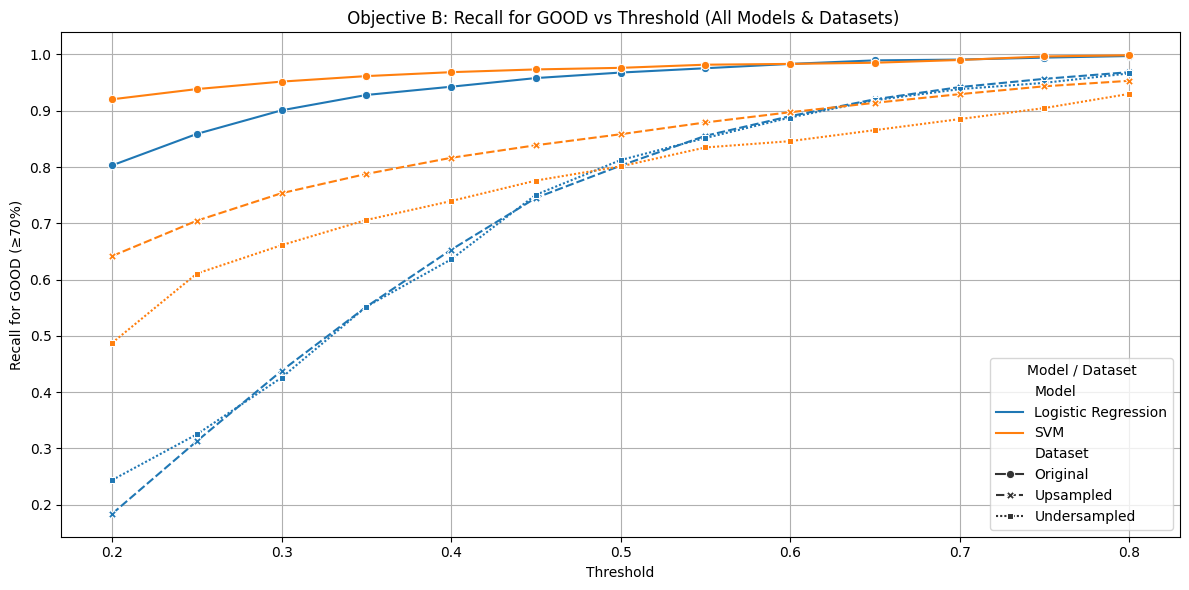

In [96]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=threshold_df, x="Threshold", y="Recall_GOOD (≥70%)", hue="Model", style="Dataset", markers=True)
plt.title(" Objective B: Recall for GOOD vs Threshold (All Models & Datasets)")
plt.xlabel("Threshold")
plt.ylabel("Recall for GOOD (≥70%)")
plt.grid(True)
plt.legend(title="Model / Dataset")
plt.tight_layout()
plt.show()


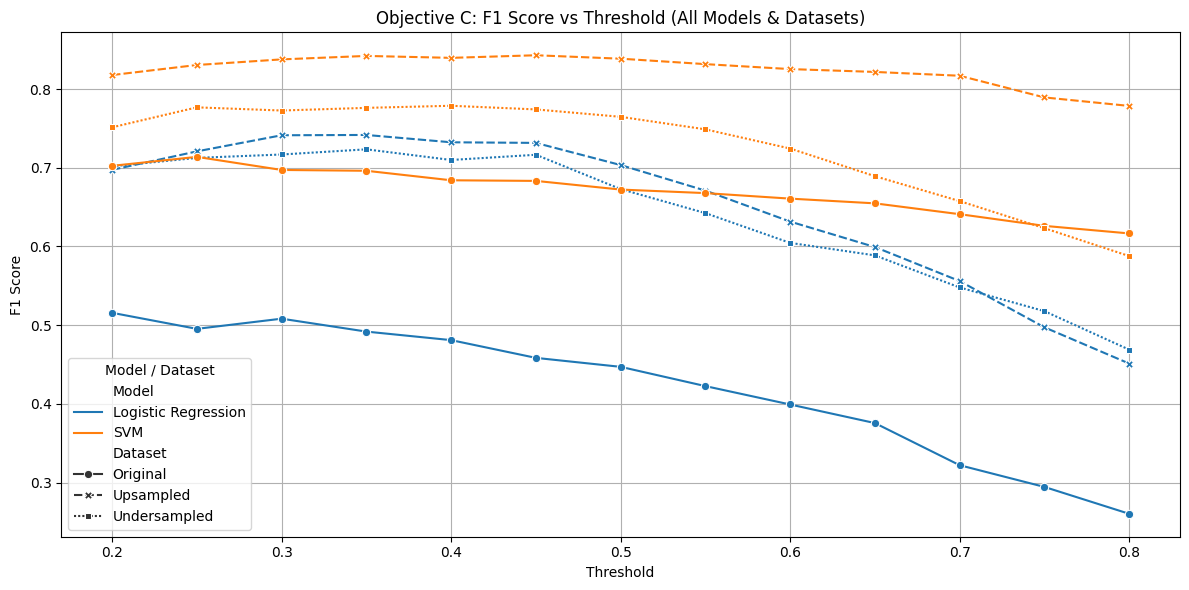

In [95]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=threshold_df, x="Threshold", y="F1 Score", hue="Model", style="Dataset", markers=True)
plt.title("Objective C: F1 Score vs Threshold (All Models & Datasets)")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend(title="Model / Dataset")
plt.tight_layout()
plt.show()


Step 4A: Cross-Validation for LR and SVM on Upsampled Dataset

In [99]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Define 5-fold Stratified Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define Pipelines
lr_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
svm_pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True))

# Evaluate Logistic Regression
lr_auc = cross_val_score(lr_pipeline, X_upsampled, y_upsampled, cv=cv, scoring='roc_auc')
lr_f1 = cross_val_score(lr_pipeline, X_upsampled, y_upsampled, cv=cv, scoring='f1')

# Evaluate SVM
svm_auc = cross_val_score(svm_pipeline, X_upsampled, y_upsampled, cv=cv, scoring='roc_auc')
svm_f1 = cross_val_score(svm_pipeline, X_upsampled, y_upsampled, cv=cv, scoring='f1')

# Print Results
print("📊 5-Fold CV Results (Upsampled Dataset)")

print("\n🔹 Logistic Regression")
print(f"ROC-AUC: {lr_auc.mean():.4f} ± {lr_auc.std():.4f}")
print(f"F1 Score: {lr_f1.mean():.4f} ± {lr_f1.std():.4f}")

print("\n🔸 SVM (RBF Kernel)")
print(f"ROC-AUC: {svm_auc.mean():.4f} ± {svm_auc.std():.4f}")
print(f"F1 Score: {svm_f1.mean():.4f} ± {svm_f1.std():.4f}")


📊 5-Fold CV Results (Upsampled Dataset)

🔹 Logistic Regression
ROC-AUC: 0.7981 ± 0.0054
F1 Score: 0.6935 ± 0.0049

🔸 SVM (RBF Kernel)
ROC-AUC: 0.9129 ± 0.0017
F1 Score: 0.8325 ± 0.0035


Step 4B: GridSearchCV for SVM (RBF) on Upsampled Dataset

In [100]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score

# Define SVM pipeline
svm_pipeline = make_pipeline(StandardScaler(), SVC(probability=True))

# Define parameter grid
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 0.1, 1]
}

# Use F1 Score as the main metric (suitable for Objective C)
grid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit on upsampled data
grid_search.fit(X_upsampled, y_upsampled)

# Output best parameters and score
print("\n✅ Best SVM Parameters (GridSearchCV):")
print(grid_search.best_params_)
print(f"Best F1 Score: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits

✅ Best SVM Parameters (GridSearchCV):
{'svc__C': 10, 'svc__gamma': 1}
Best F1 Score: 0.8586


Final comparision

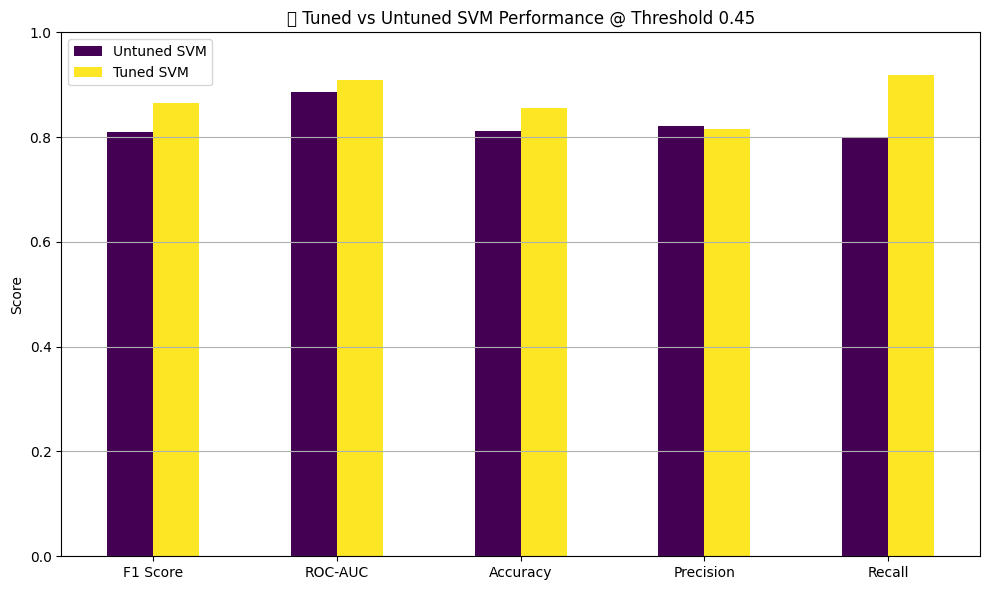

📋 Untuned SVM Classification Report:

              precision    recall  f1-score   support

           0      0.804     0.826     0.815       357
           1      0.821     0.798     0.810       357

    accuracy                          0.812       714
   macro avg      0.813     0.812     0.812       714
weighted avg      0.813     0.812     0.812       714


📋 Tuned SVM Classification Report:

              precision    recall  f1-score   support

           0      0.907     0.793     0.846       357
           1      0.816     0.919     0.864       357

    accuracy                          0.856       714
   macro avg      0.861     0.856     0.855       714
weighted avg      0.861     0.856     0.855       714



In [103]:
# 1. Refit both models on training data
svm_pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True))
tuned_svm = grid_search.best_estimator_

svm_pipeline.fit(X_train, y_train)
tuned_svm.fit(X_train, y_train)

# 2. Predict probabilities
untuned_probs = svm_pipeline.predict_proba(X_test)[:, 1]
tuned_probs = tuned_svm.predict_proba(X_test)[:, 1]

# 3. Predict labels with threshold = 0.45
untuned_preds = (untuned_probs >= 0.45).astype(int)
tuned_preds = (tuned_probs >= 0.45).astype(int)

# 4. Collect metrics
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt

def get_metrics(y_true, y_pred, y_prob):
    return {
        "F1 Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred)
    }

untuned_metrics = get_metrics(y_test, untuned_preds, untuned_probs)
tuned_metrics = get_metrics(y_test, tuned_preds, tuned_probs)

# 5. Plot comparison
comparison_df = pd.DataFrame([untuned_metrics, tuned_metrics], index=["Untuned SVM", "Tuned SVM"])
comparison_df.T.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("📊 Tuned vs Untuned SVM Performance @ Threshold 0.45")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 6. Print classification reports
print("📋 Untuned SVM Classification Report:\n")
print(classification_report(y_test, untuned_preds, digits=3))

print("\n📋 Tuned SVM Classification Report:\n")
print(classification_report(y_test, tuned_preds, digits=3))
